In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# loading the dataset
day_ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/day.csv')
hour_ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hour.csv')

In [ ]:
hour_ds

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

# preprocessing the data

# extracting day of week
hour_ds['dteday'] = pd.to_datetime(hour_ds['dteday'])
hour_ds['day of week'] = hour_ds['dteday'].dt.dayofweek

# extracting cyclical features using sine and cosine transformations
cyclical_features = ['season', 'mnth', 'weekday', 'hr']
for feature in cyclical_features:
  hour_ds[f'{feature}_sin'] = np.sin(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())
  hour_ds[f'{feature}_cos'] = np.cos(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())

# creating binary variables for time indicators
hour_ds['afternoon'] = np.where((hour_ds['hr'] >= 12) & (hour_ds['hr'] <= 18), 1, 0)
hour_ds['working hour'] = np.where((hour_ds['hr'] >= 9) & (hour_ds['hr'] <= 17), 1, 0)
hour_ds['holiday'] = np.where(hour_ds['holiday'] == 1, 1, 0)
hour_ds['working day'] = np.where(hour_ds['workingday'] == 1, 1, 0)
hour_ds['month start'] = np.where(hour_ds['dteday'].dt.is_month_start, 1, 0)
hour_ds['quarter start'] = np.where(hour_ds['dteday'].dt.is_quarter_start, 1, 0)

# creating lagged values
target = ['cnt', 'casual', 'registered'] # target variables

# lagged (recent)
for feature in target:
  for i in range(1, 4):
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

# lagged (distant)
for feature in target:
  for i in [24, 48, 168]:
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

print(hour_ds.shape)
hour_df = hour_ds.dropna()
print(hour_df.shape)

(17379, 49)
(17211, 49)


In [ ]:
hour_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered_lag3,cnt_lag24,cnt_lag48,cnt_lag168,casual_lag24,casual_lag48,casual_lag168,registered_lag24,registered_lag48,registered_lag168
168,169,2011-01-08,1,0,1,7,0,6,0,2,...,1.0,84.0,36.0,16.0,8.0,0.0,3.0,76.0,36.0,13.0
169,170,2011-01-08,1,0,1,8,0,6,0,3,...,5.0,210.0,95.0,40.0,20.0,0.0,8.0,190.0,95.0,32.0
170,171,2011-01-08,1,0,1,9,0,6,0,3,...,2.0,134.0,219.0,32.0,9.0,3.0,5.0,125.0,216.0,27.0
171,172,2011-01-08,1,0,1,10,0,6,0,2,...,8.0,63.0,122.0,13.0,16.0,6.0,3.0,47.0,116.0,10.0
172,173,2011-01-08,1,0,1,11,0,6,0,2,...,15.0,67.0,45.0,1.0,19.0,3.0,0.0,48.0,42.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,184.0,102.0,97.0,26.0,16.0,7.0,6.0,86.0,90.0,20.0
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,150.0,72.0,66.0,18.0,9.0,2.0,4.0,63.0,64.0,14.0
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,112.0,47.0,60.0,23.0,5.0,4.0,6.0,42.0,56.0,17.0
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,108.0,36.0,54.0,22.0,6.0,3.0,13.0,30.0,51.0,9.0


In [ ]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaled_features = [
    'season_sin',
    'season_cos',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'cnt',
    'casual',
    'registered',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

# Store the original index
original_index = hour_df.index

scaled_df = pd.DataFrame(scaler.fit_transform(hour_df[scaled_features]), columns=scaled_features)

# Reset the index of scaled_df to match the original DataFrame
scaled_df.index = original_index

# Drop the original features using .loc or .iloc
hour_df = hour_df.loc[:, ~hour_df.columns.isin(scaled_features)]

hour_df = pd.concat([hour_df, scaled_df], axis=1)

# selecting relevant features
final_cols = [
    'season_sin',
    'season_cos',
    'day of week',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'holiday',
    'afternoon',
    'working hour',
    'working day',
    'month start',
    'quarter start',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

target = 'cnt'

hour_df_final = hour_df[final_cols + [target]]

print(hour_df_final.shape)
hour_final = hour_df_final.dropna()
print(hour_final.shape)

(17211, 22)
(17211, 22)


In [ ]:
hour_final

,season_sin,season_cos,day of week,mnth_sin,mnth_cos,weekday_sin,weekday_cos,hr_sin,hr_cos,holiday,...,working day,month start,quarter start,cnt_lag1,cnt_lag2,cnt_lag3,cnt_lag24,cnt_lag48,cnt_lag168,cnt
168,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.972231,3.294374e-01,0,...,0,0,0,0.001025,0.004098,0.000000,0.085041,0.035861,0.015369,0.008197
169,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.909439,2.079713e-01,0,...,0,0,0,0.008197,0.001025,0.004098,0.214139,0.096311,0.039959,0.014344
170,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.816281,1.079902e-01,0,...,0,0,0,0.014344,0.008197,0.001025,0.136270,0.223361,0.031762,0.019467
171,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.699666,3.690921e-02,0,...,0,0,0,0.019467,0.014344,0.008197,0.063525,0.123975,0.012295,0.061475
172,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.568242,5.551115e-17,0,...,0,0,0,0.061475,0.019467,0.014344,0.067623,0.045082,0.000000,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.055020,7.287694e-01,0,...,1,0,0,0.123975,0.167008,0.218238,0.103484,0.098361,0.025615,0.120902
17375,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.133728,8.405339e-01,0,...,1,0,0,0.120902,0.123975,0.167008,0.072746,0.066598,0.017418,0.090164
17376,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.239601,9.268691e-01,0,...,1,0,0,0.090164,0.120902,0.123975,0.047131,0.060451,0.022541,0.091189
17377,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.364786,9.813719e-01,0,...,1,0,0,0.091189,0.090164,0.120902,0.035861,0.054303,0.021516,0.061475


Note to future: We need to calculate confidence intervals and prediction intervals too. Explanation for it is as:

Bootstrapping and RNN Training

Bootstrapping: Instead of using the entire dataset to train a single model, multiple smaller datasets (bootstrap samples) are created by sampling with replacement from the original training dataset.

Separate RNN Training: Each bootstrap sample is used to train a separate RNN model. This results in multiple models, each trained on slightly different data.

Point Prediction: The final prediction for a given point in time (yˆi) is the average of the predictions from all the trained RNN models.

Confidence Intervals

Purpose: Confidence intervals give a range within which we expect the true average (mean) of our predictions to lie. It's not about individual predictions, but about the average accuracy of the model.

Calculation:

Center of Interval: The mean of all model predictions for each point.

Variance Calculation: The variance of the predictions is calculated, giving a measure of how much the predictions differ from the mean.

Confidence Interval: Using the mean and variance, and a value from the t-distribution (for statistical significance), the confidence interval is computed for each point.

Prediction Intervals

Purpose: Prediction intervals are more practical in forecasting. They provide a range within which we expect the actual future values to lie.

More Complex Calculation:

Noise Variance Estimation: This involves computing the variance of the residuals (the differences between actual values and predictions).

Residual Predictor: An additional network is trained to predict these residuals. This network is trained on the validation set.

Total Variance: The variance from the point predictions and the variance from the residual predictions are combined to estimate the total variance for each point.

Prediction Interval: Using this total variance and a value from the t-distribution, prediction intervals are computed for each point.

In [ ]:
import numpy as np
import keras

class SequenceDataGenerator(keras.utils.Sequence):
    def __init__(self, data, targets, sequence_length, batch_size):
        self.data = data
        self.targets = targets
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.data) - self.sequence_length) // self.batch_size

    def __getitem__(self, idx):
        start_index = idx * self.batch_size
        batch_x = []
        batch_y = []
        for i in range(start_index, start_index + self.batch_size):
            end_index = i + self.sequence_length
            if end_index < len(self.data) and (end_index - 1) < len(self.targets):
                seq_x = self.data[i:end_index]
                seq_y = self.targets[end_index - 1]
                batch_x.append(seq_x)
                batch_y.append(seq_y)
        return np.array(batch_x), np.array(batch_y)
    def get_all_y_values(self):
        all_y_values = []
        for idx in range(len(self)):
            _, batch_y = self[idx]
            all_y_values.extend(batch_y)
        return np.array(all_y_values)


In [ ]:
#Original Model
import random


from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# references: https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html

sequence_length = 16
batch_size = 128

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16

y_test = future_test_set[target]

# evaluation
test_generator = SequenceDataGenerator(X_test.values, y_test.values, sequence_length, batch_size)


# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Initialize lists to store models and their predictions
baseline_trained_models = []
baseline_predictions = []

# Bootstrapping and training loop
bootstrap_samples = 3 #For test purposes, real value is 50
for i in range(bootstrap_samples):
    # Sequential train-test split for time series data
    random_float = random.uniform(0, 0.2)

    # Calculate the start and end indices for the validation set
    total_length = len(train_set)
    val_start = int(total_length * random_float)
    val_end = int(total_length * (random_float + 0.8))

    # Ensure val_end does not exceed the total length of the dataset
    val_end = min(val_end, total_length)

    # Split the data into training and validation sets
    train_set_i = train_set[val_start:val_end]
    val_set = pd.concat([train_set[:val_start], train_set[val_end:]])



    # Bootstrap sampling
    X_train = train_set_i[final_cols]
    y_train = train_set_i[target]
    y_train_adjusted = y_train[15:]
    train_generator = SequenceDataGenerator(X_train.values, y_train.values, sequence_length, batch_size)

    X_val = val_set[final_cols]
    y_val = val_set[target]
    y_val_adjusted = y_val[15:]
    val_generator = SequenceDataGenerator(X_val.values, y_val.values, sequence_length, batch_size)

    # Build a new LSTM model
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(16, X_train.shape[1]), dropout=0.5))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(train_generator, epochs=64, validation_data=val_generator, shuffle=True) #epoch must be 128

    # Store the trained model
    baseline_trained_models.append(model)

    # Evaluate the model on the test set and store predictions
    # Note: Replace X_test_reshaped and y_test with your actual test data reshaped accordingly

    model_predictions = model.predict(test_generator)
    baseline_predictions.append(model_predictions)

    print("Finished sample " + str(i+1))

# You can now use the stored predictions to calculate prediction intervals

Epoch 1/64
75/75 [==============================] - 5s 26ms/step - loss: 0.0338 - val_loss: 0.0284
Epoch 2/64
75/75 [==============================] - 1s 13ms/step - loss: 0.0129 - val_loss: 0.0197
Epoch 3/64
75/75 [==============================] - 1s 13ms/step - loss: 0.0106 - val_loss: 0.0167
Epoch 4/64
75/75 [==============================] - 1s 13ms/step - loss: 0.0098 - val_loss: 0.0148
Epoch 5/64
75/75 [==============================] - 1s 13ms/step - loss: 0.0088 - val_loss: 0.0131
Epoch 6/64
75/75 [==============================] - 1s 14ms/step - loss: 0.0084 - val_loss: 0.0125
Epoch 7/64
75/75 [==============================] - 1s 13ms/step - loss: 0.0081 - val_loss: 0.0123
Epoch 8/64
75/75 [==============================] - 1s 13ms/step - loss: 0.0081 - val_loss: 0.0136
Epoch 9/64
75/75 [==============================] - 1s 16ms/step - loss: 0.0079 - val_loss: 0.0130
Epoch 10/64
75/75 [==============================] - 2s 22ms/step - loss: 0.0075 - val_loss: 0.0129
Epoch 11/

(5120,)

In [ ]:
from sklearn.metrics import median_absolute_error, r2_score

# evaluation
def evaluate_pred(predictions, actual):
  rmses, smapes, r_sqs, msaes, medaes = [], [], [], [], []

  for pred in predictions:
    pred_flat = pred.flatten()

    errors = pred_flat - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)

    smape = (100 / len(pred)) * np.sum(2 * np.abs(pred_flat - actual) / (np.abs(actual) + np.abs(pred_flat)))

    r_squared = r2_score(actual, pred_flat)

    mae = np.abs(errors).mean()

    medae = median_absolute_error(actual, pred_flat)

    rmses.append(rmse)
    smapes.append(smape)
    r_sqs.append(r_squared)
    msaes.append(mae)
    medaes.append(medae)

  rmse = np.mean(rmses)
  smapes = np.mean(smapes)
  r_squared = np.mean(r_sqs)
  mae = np.mean(msaes)
  medae = np.mean(medaes)

  return rmse, smape, r_squared, mae, medae

baseline_actual = test_generator.get_all_y_values()

rmse, smape, r_squared, mae, medae = evaluate_pred(baseline_predictions, baseline_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE"],
    "Value": [100 * rmse, smape, 100 * r_squared, 100 * mae, 100 * medae]
})

print('Baseline Model Evaluation')
print(metrics_df)
# loss = baseline_trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
# print(f'Baseline Model Loss on Test Set: {loss}')

In [ ]:
def extract_sequences(data, sequence_length, num_sequences):
    sequences = []
    for i in range(num_sequences):
        # Check if we can extract a full sequence of the desired length
        if i + sequence_length <= len(data):
            sequence = data[i:i + sequence_length]
            sequences.append(sequence)
        else:
            break  # Break if we reach the end of the data
    return np.array(sequences)

# Extract 100 sequences of 16 time steps
sequence_length = 16
num_sequences = 100
X_test_sequences = extract_sequences(X_test.values, sequence_length, num_sequences)

In [ ]:
# generating one-step predictions for first 100 steps of test set forecasts
def onestep_forecasts(models, X):
  forecasts = []
  for i in range(len(X)):
    sum_of_predictions = 0
    for model_i in range(len(models)):
      forecast_step = models[model_i].predict(X[i].reshape(1, X.shape[1], X.shape[2]))
      sum_of_predictions += forecast_step[0, 0]
    forecasts.append(sum_of_predictions / len(models))

  return np.array(forecasts)

In [ ]:
one_step_forecasts = onestep_forecasts(baseline_trained_models, X_test_sequences)
one_step_forecasts

In [ ]:
# generating multi-step forecasts for the first 100 steps of test set using only 16 steps
def multistep_forecasts(models, X, n_steps, X_known):
    forecasts = []
    current_input = X.reshape(1, X.shape[0], X.shape[1])

    for i in range(n_steps):
      sum_of_predictions = 0
      for model_i in range(len(models)):
        forecast_step = models[model_i].predict(current_input.reshape(1, current_input.shape[1], current_input.shape[2]))
        sum_of_predictions += forecast_step[0, 0]
      forecasts.append(sum_of_predictions / len(models))

      # Update the input for the next time step
      current_input = np.roll(current_input, shift=-1, axis=1)

      #Update new input accordingly
      for k in range(15):
        current_input[0, -1, k] = X_known[i, k]
      current_input[0, -1, 15] = sum_of_predictions / len(models)
      current_input[0, -1, 16] = current_input[0, -2, 15]
      current_input[0, -1, 17] = current_input[0, -2, 16]

      #This part doesn't work too good, better approach may be used---------------------------------------------------
      if i >= 24 and i <  24 + current_input.shape[1]:
        current_input[0, -1, 18] = X[i - 24][15]
        current_input[0, -1, 19] = X[i - 24][18]
      if i >= 48 and i <  48 + current_input.shape[1]:
        current_input[0, -1, 19] = X[i - 48][15]
      if i >= 96 and i <  96 + current_input.shape[1]:
        current_input[0, -1, 20] = X[i - 96][19]


    return np.array(forecasts)

In [ ]:
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts = multistep_forecasts(baseline_trained_models, X_test_reshaped[0], n_steps, X_test.values[16:16+n_steps])

In [ ]:
print(multi_step_forecasts)

In [ ]:
import matplotlib.pyplot as plt

# plotting true and predicted lines for each set of forecasts

# one-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), one_step_forecasts, label='predicted', marker='o', linestyle='--')
# calculating upper and lower bounds for prediction intervals
# plt.fill_between(np.arange(1, 101),
#                  one_step_forecasts - 1.96 * np.std(one_step_forecasts),
#                  one_step_forecasts + 1.96 * np.std(one_step_forecasts),
#                  alpha=0.3)
plt.title('One-step forecasts')
plt.legend()
plt.show()

# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')
# plt.fill_between(np.arange(1, 101),
#                  multi_step_forecasts[:100] - 1.96 * np.std(multi_step_forecasts[:100]),
#                  multi_step_forecasts[:100] + 1.96 * np.std(multi_step_forecasts[:100]),
#                  alpha=0.3)
plt.title('Multi-step forecasts')
plt.legend()
plt.show()

In [ ]:
class SequenceDataGeneratorBatchOverlap(keras.utils.Sequence):
    def __init__(self, data, targets, sequence_length, batch_size, overlap_size):
        self.data = data
        self.targets = targets
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.overlap_size = overlap_size

    def __len__(self):
        # Adjust the length calculation to account for overlap
        total_sequences = len(self.data) - self.sequence_length + 1
        return (total_sequences - self.overlap_size) // (self.batch_size - self.overlap_size)

    def __getitem__(self, idx):
        start_index = idx * (self.batch_size - self.overlap_size)
        batch_x = []
        batch_y = []
        for i in range(start_index, start_index + self.batch_size):
            end_index = i + self.sequence_length
            if end_index <= len(self.data):
                seq_x = self.data[i:end_index]
                seq_y = self.targets[end_index - 1] if (end_index - 1) < len(self.targets) else None
                if seq_y is not None:
                    batch_x.append(seq_x)
                    batch_y.append(seq_y)
        return np.array(batch_x), np.array(batch_y)

In [ ]:
#Overlap model
import random


from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# references: https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html

sequence_length = 16
batch_size = 128

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16

y_test = future_test_set[target]
y_test_adjusted = y_test[15:]

# evaluation
test_generator = SequenceDataGenerator(X_test.values, y_test.values, sequence_length, batch_size)


# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Initialize lists to store models and their predictions
bo_trained_models = []
bo_predictions = []

# Bootstrapping and training loop
bootstrap_samples = 3 #For test purposes, real value is 50
for i in range(bootstrap_samples):
    # Sequential train-test split for time series data
    random_float = random.uniform(0, 0.2)

    # Calculate the start and end indices for the validation set
    total_length = len(train_set)
    val_start = int(total_length * random_float)
    val_end = int(total_length * (random_float + 0.8))

    # Ensure val_end does not exceed the total length of the dataset
    val_end = min(val_end, total_length)

    # Split the data into training and validation sets
    train_set_i = train_set[val_start:val_end]
    val_set = pd.concat([train_set[:val_start], train_set[val_end:]])



    # Bootstrap sampling
    X_train = train_set_i[final_cols]
    y_train = train_set_i[target]
    y_train_adjusted = y_train[15:]
    train_generator = SequenceDataGeneratorBatchOverlap(X_train.values, y_train.values, sequence_length, batch_size, 16)

    X_val = val_set[final_cols]
    y_val = val_set[target]
    y_val_adjusted = y_val[15:]
    val_generator = SequenceDataGenerator(X_val.values, y_val.values, sequence_length, batch_size)

    # Build a new LSTM model
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(16, X_train.shape[1]), dropout=0.5))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(train_generator, epochs=64, validation_data=val_generator, shuffle=True) #epoch must be 128

    # Store the trained model
    bo_trained_models.append(model)

    # Evaluate the model on the test set and store predictions
    # Note: Replace X_test_reshaped and y_test with your actual test data reshaped accordingly

    model_predictions = model.predict(test_generator)
    bo_predictions.append(model_predictions)

    print("Finished sample " + str(i+1))

# You can now use the stored predictions to calculate prediction intervals


In [ ]:
def reshape_with_overlap(X, time_steps, overlap, num_features):
    # Total number of sequences to create
    num_sequences = (X.shape[0] - time_steps) // (time_steps - overlap) + 1

    # Initialize the 3D array for output
    output = np.zeros((num_sequences, time_steps, num_features))

    for i in range(num_sequences):
        start = i * (time_steps - overlap)
        end = start + time_steps
        output[i] = X[start:end]

    return output

In [ ]:
bo_actual = test_generator.get_all_y_values()

# evaluation
rmse, smape, r_squared, mae, medae = evaluate_pred(bo_predictions, bo_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE"],
    "Value": [100 * rmse, smape, 100 * r_squared, 100 * mae, 100 * medae]
})

print('Batch Overlap Model Evaluation')
print('--------------------')
print(metrics_df)
# loss = bo_trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
# print(f'Batch Overlap Model Loss on Test Set: {loss}')

In [ ]:
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts = multistep_forecasts(bo_trained_models, X_test_reshaped[0], n_steps, X_test.values[16:16+n_steps])

In [ ]:
# plotting results for LSTM with Batch Overlap predictions

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')

plt.title('Multi-step forecasts of LSTM with Batch Overlap')
plt.legend()
plt.show()

In [ ]:
#Encoder Decoder LSTM Model
#reference https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/#:~:text=Implement%20Encoder%2DDecoder%20LSTMs%20in,encoded%20character%20at%20a%20time.

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.layers import LSTM, RepeatVector
from keras.layers import TimeDistributed, Dense

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16
X_test_reshaped = X_test.values[:expected_shape_test-16].reshape(((X_test.shape[0] // 16) - 1, 16, X_test.shape[1]))
y_test = future_test_set[target]
y_test_adjusted = y_test.values[15:expected_shape_test - 1].reshape(((y_test.shape[0] // 16) - 1, 16, 1))

# for evaluation
ed_actual = y_test_adjusted

# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Initialize lists to store models and their predictions
ed_trained_models = []
ed_predictions = []

# Bootstrapping and training loop
bootstrap_samples = 1
for i in range(bootstrap_samples):
    # Bootstrap sampling
    train_bs = resample(train_set, replace=True)
    X_train = train_bs[final_cols]
    expected_shape_train = (X_train.shape[0] // 16) * 16
    y_train = train_bs[target]
    y_train_adjusted = y_train.values[15:expected_shape_train - 1].reshape(((y_train.shape[0] // 16) - 1, 16, 1))

    val_bs = train_set.loc[~train_set.index.isin(train_bs.index)]
    X_val = val_bs[final_cols]
    expected_shape_val = (X_val.shape[0] // 16) * 16
    y_val = val_bs[target]
    y_val_adjusted = y_val.values[15:expected_shape_val - 1].reshape(((y_val.shape[0] // 16) - 1, 16, 1))


    # Reshape data for LSTM
    X_train_reshaped = X_train.values[:expected_shape_train - 16].reshape(((X_train.shape[0] // 16) - 1, 16, X_train.shape[1]))
    X_val_reshaped = X_val.values[:expected_shape_val - 16].reshape(((X_val.shape[0] // 16) - 1, 16, X_val.shape[1]))

    # Build an encoder LSTM model
    model = Sequential()
    model.add(LSTM(units=16, input_shape=(16, X_train.shape[1]), dropout=0.5))

    # Build a decoder LSTM model
    model.add(RepeatVector(16))
    model.add(LSTM(units=16, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Train the model
    model.fit(X_train_reshaped, y_train_adjusted, epochs=32, batch_size=4, validation_data=(X_val_reshaped, y_val_adjusted), shuffle=True)

    # Store the trained model
    ed_trained_models.append(model)

    model_predictions = model.predict(X_test_reshaped)
    ed_predictions.append(model_predictions)

    print("Finished sample " + str(i+1))


In [ ]:
# evaluation
def evaluate_pred_ed(predictions, actual):
  print(len(predictions[0]))
  print(actual.shape)
  rmses, smapes, r_sqs, msaes, medaes = [], [], [], [], []

  for pred in predictions:
    pred_flat = pred.flatten()

    errors = pred_flat - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)

    smape = (100 / len(pred)) * np.sum(2 * np.abs(pred_flat - actual) / (np.abs(actual) + np.abs(pred_flat)))

    r_squared = r2_score(actual, pred_flat)

    mae = np.abs(errors).mean()

    medae = median_absolute_error(actual, pred_flat)

    rmses.append(rmse)
    smapes.append(smape)
    r_sqs.append(r_squared)
    msaes.append(mae)
    medaes.append(medae)

  rmse = np.mean(rmses)
  smapes = np.mean(smapes)
  r_squared = np.mean(r_sqs)
  mae = np.mean(msaes)
  medae = np.mean(medaes)

  return rmse, smape, r_squared, mae, medae

rmse, smape, r_squared, mae, medae = evaluate_pred_ed(ed_predictions, ed_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE"],
    "Value": [100 * rmse, smape, 100 * r_squared, 100 * mae, 100 * medae]
})

print('Encoder-Decoder Model Evaluation')
print(metrics_df)
# loss = ed_trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
# print(f'Encoder-Decoder Model Loss on Test Set: {loss}')

321
(321, 16, 1)


ValueError: ignored

In [ ]:
# generating multi-step forecasts for encoder-decoder model
def multistep_forecasts_ed(model, X, n_steps):
    current_step = 0
    forecasts = []
    for i in range(n_steps):
      if current_step > n_steps:
        break
      current_input = X[i].reshape(1, X[i].shape[0], X[i].shape[1])
      sum_of_predictions = np.zeros((current_input.shape[1]))
      for model_i in range(len(model)):
        forecast_step = model[model_i].predict(current_input.reshape(1, current_input.shape[1], current_input.shape[2]))
        sum_of_predictions += forecast_step.reshape(-1)
      forecasts = np.append(forecasts, sum_of_predictions / len(model))
      current_step += current_input.shape[1]
    return np.array(forecasts)

In [ ]:
# multi-step forecasts for Encoder Decoder LSTM
n_steps = 100
multi_step_forecasts = multistep_forecasts_ed(ed_trained_models, X_test_reshaped, n_steps)

1/1 [==============================] - 0s 20ms/step


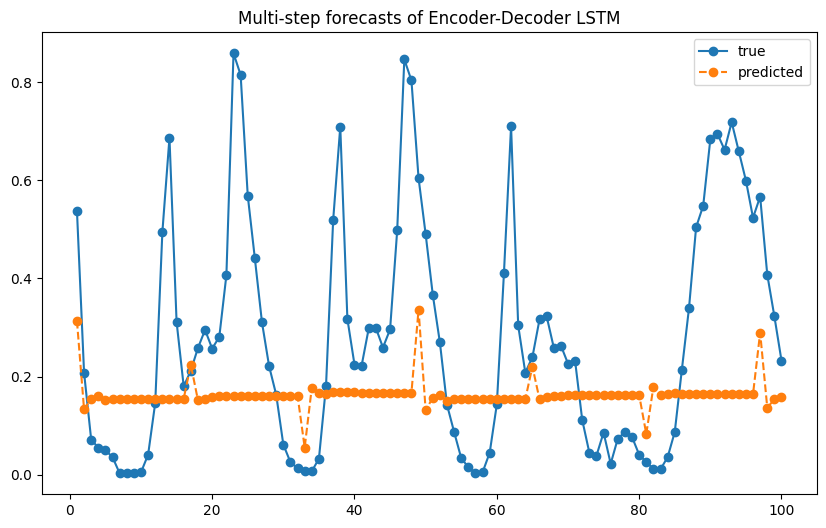

In [ ]:
# plotting results for Encoder-Decoder LSTM predictions

# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')
plt.title('Multi-step forecasts of Encoder-Decoder LSTM')
plt.legend()
plt.show()